In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist, squareform

from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [2]:
from tqdm import tqdm

In [3]:
df = pd.read_csv('df_with_outlier.csv')

In [4]:
df.head()

name  duration_min  explicit  popularity  \
0                             Long Road      0.056710         0    0.489362   
1  Daniâl My Son, Where Did You Vanish?      0.105897         0    0.000000   
2                    Ondskapens Galakse      0.079024         0    0.031915   
3                       Can't Look Away      0.063530         0    0.244681   
4                         Thunderground      0.072736         0    0.265957   

                  artists              album_name  danceability  energy  key  \
0           Funki Porcini           Hed Phone Sex         0.690   0.513    5   
1           Siavash Amini    A Trail of Laughters         0.069   0.196    1   
2               Kvelertak              Nattesferd         0.363   0.854    2   
3       The Wood Brothers       One Drop of Truth         0.523   0.585    5   
4  The Darkraver;DJ Vince  Happy Hardcore Top 100         0.643   0.687    7   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0  0.702298   1.0       0.0975      0.302000           0.53600     0.281   
1  0.469376   0.0       0.0805      0.283000           0.93400     0.360   
2  0.798793   1.0       0.0397      0.000089           0.80000     0.262   
3  0.833678   1.0       0.0765      0.066400           0.00127     0.117   
4  0.724866   1.0       0.0539      0.000576           0.09690     0.299   

   valence     tempo  features_duration_ms  time_signature   n_beats  \
0   0.6350  0.644920                241760             4.0  0.077164   
1   0.0336  0.342800                444000             4.0  0.083968   
2   0.4890  0.528865                333507             4.0  0.088732   
3   0.3850  0.638839                269800             4.0  0.084241   
4   0.6370  0.652788                307652             4.0  0.099755   

     n_bars  popularity_confidence  processing        genre  
0  0.064977                    NaN    1.279305      j-dance  
1  0.071429                    NaN    2.367412      iranian  
2  0.074654                    NaN    3.700483  black-metal  
3  0.071429                  0.469    1.279305    bluegrass  
4  0.084332                    NaN    4.067086        happy

In [4]:
nunique = df.nunique(); nunique
cols = df.columns

categorical = [col for col in cols if nunique[col] <= 20]
objects = df.select_dtypes(include='object').columns

df_train = df.drop(columns = set(list(objects)+categorical+['features_duration_ms','popularity_confidence']))

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_min      15000 non-null  float64
 1   popularity        15000 non-null  float64
 2   danceability      15000 non-null  float64
 3   energy            15000 non-null  float64
 4   loudness          15000 non-null  float64
 5   speechiness       15000 non-null  float64
 6   acousticness      15000 non-null  float64
 7   instrumentalness  15000 non-null  float64
 8   liveness          15000 non-null  float64
 9   valence           15000 non-null  float64
 10  tempo             15000 non-null  float64
 11  n_beats           15000 non-null  float64
 12  n_bars            15000 non-null  float64
dtypes: float64(13)
memory usage: 1.5 MB


In [6]:
df_train.head()

duration_min  popularity  danceability  energy  loudness  speechiness  \
0      0.056710    0.489362         0.690   0.513  0.702298       0.0975   
1      0.105897    0.000000         0.069   0.196  0.469376       0.0805   
2      0.079024    0.031915         0.363   0.854  0.798793       0.0397   
3      0.063530    0.244681         0.523   0.585  0.833678       0.0765   
4      0.072736    0.265957         0.643   0.687  0.724866       0.0539   

   acousticness  instrumentalness  liveness  valence     tempo   n_beats  \
0      0.302000           0.53600     0.281   0.6350  0.644920  0.077164   
1      0.283000           0.93400     0.360   0.0336  0.342800  0.083968   
2      0.000089           0.80000     0.262   0.4890  0.528865  0.088732   
3      0.066400           0.00127     0.117   0.3850  0.638839  0.084241   
4      0.000576           0.09690     0.299   0.6370  0.652788  0.099755   

     n_bars  
0  0.064977  
1  0.071429  
2  0.074654  
3  0.071429  
4  0.084332

In [7]:
df_train.describe()

duration_min    popularity  danceability        energy      loudness  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean       0.057938      0.291741      0.551063      0.656231      0.771272   
std        0.031129      0.197740      0.194239      0.264371      0.113990   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.041690      0.148936      0.441000      0.480000      0.738223   
50%        0.053321      0.255319      0.580000      0.709000      0.801488   
75%        0.068176      0.446809      0.695000      0.884000      0.843282   
max        1.000000      1.000000      0.980000      1.000000      1.000000   

        speechiness  acousticness  instrumentalness      liveness  \
count  15000.000000  15000.000000      15000.000000  15000.000000   
mean       0.083779      0.303896          0.286734      0.216790   
std        0.086709      0.329536          0.382930      0.195295   
min        0.000000      0.000000          0.000000      0.000000   
25%        0.037300      0.009745          0.000000      0.097900   
50%        0.051000      0.155000          0.003130      0.131000   
75%        0.088600      0.573000          0.744000      0.280000   
max        0.939000      0.996000          1.000000      0.994000   

            valence         tempo       n_beats        n_bars  
count  15000.000000  15000.000000  15000.000000  15000.000000  
mean       0.436853      0.558288      0.068299      0.059167  
std        0.277220      0.144795      0.038199      0.034615  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.196000      0.453187      0.044502      0.038249  
50%        0.416000      0.563147      0.062738      0.053917  
75%        0.664000      0.643857      0.085057      0.073272  
max        0.995000      1.000000      1.000000      1.000000

# Clustering

## Kmeans

In [8]:
%%time

n_clusters = range(2, 26)
sse = []
silhouette = []
for n in tqdm(n_clusters):
    kmeans = KMeans(n_clusters=n, n_init=10, max_iter=100)
    kmeans.fit(df_train)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_train, kmeans.labels_))

100%|███████████████████████████████████████████| 24/24 [00:46<00:00,  1.93s/it]

CPU times: user 1min 46s, sys: 1min 35s, total: 3min 22s
Wall time: 46.4 s


In [9]:
len(range(2, len(silhouette)+1))

23

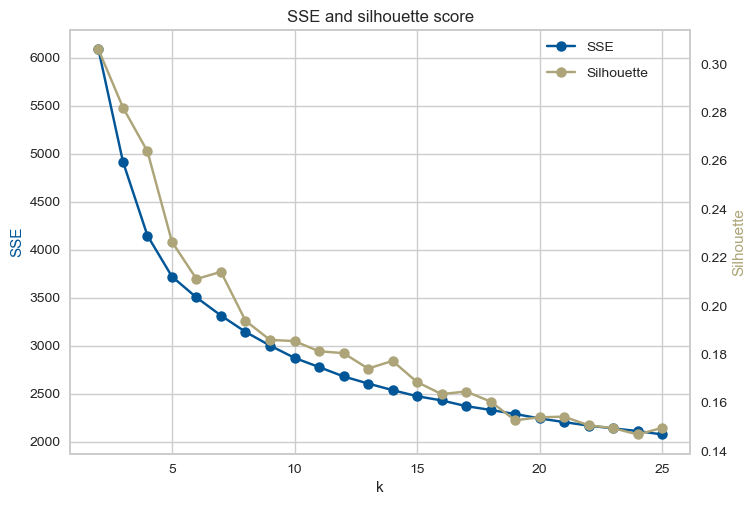

In [11]:
colors = ['#015697', '#ada579']

fig, ax1 = plt.subplots()


ax1.plot(range(2, len(sse)+2), sse, color=colors[0], marker='.', markersize = 15, label='SSE')
ax1.set_xlabel('k')
ax1.set_ylabel('SSE', color=colors[0])


ax2 = ax1.twinx()


ax2.plot(range(2, len(sse)+2), silhouette, color=colors[1], marker='.', markersize = 15, label='Silhouette')
ax2.set_ylabel('Silhouette', color=colors[1])


ax1.legend(loc=(0.76,0.93))
ax2.legend(loc=(0.76,0.87))

ax2.grid(axis='y')

plt.title('SSE and silhouette score')
plt.show()

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

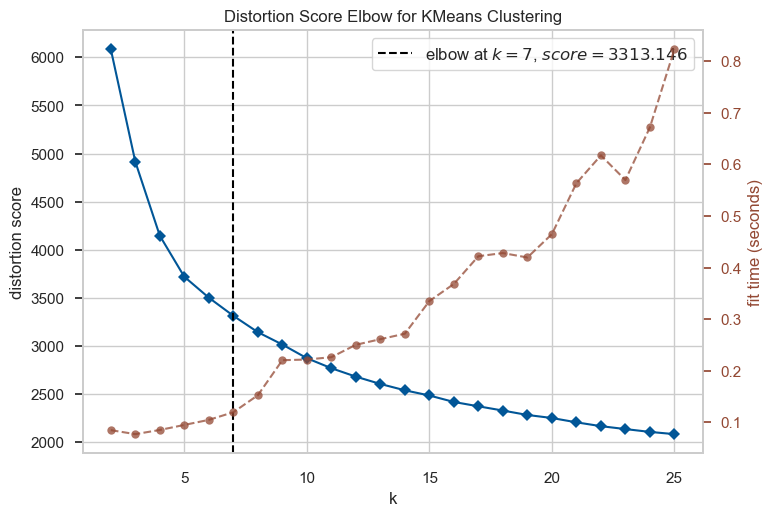

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [67]:
colors = ['#934833', '#015697', 'black']

model = KMeans(random_state=0)
plot = KElbowVisualizer(model, k=(2,26))

for i, el in enumerate(plot.colors):
    plot.colors[el] = colors[i]

plot.fit(df_train)        # Fit the data to the visualizer


fig = visualizer.fig
ax = visualizer.ax
    
plot.show()


In [75]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100)
kmeans.fit(df_train)

hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(df_train, kmeans.labels_))

labels {0: 8713, 1: 3330, 2: 2957}
sse 4915.951912460697
silhouette 0.28200376015883616


In [35]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=100)
kmeans.fit(df_train)

hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(df_train, kmeans.labels_))

labels {0: 3414, 1: 2594, 2: 3057, 3: 1775, 4: 4160}
sse 3719.1269060298205
silhouette 0.2265332731177027


In [77]:
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=100)
kmeans.fit(df_train)

hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(df_train, kmeans.labels_))

labels {0: 820, 1: 1474, 2: 3733, 3: 2427, 4: 1779, 5: 1673, 6: 3094}
sse 3313.1404869626253
silhouette 0.21402377347525883


In [103]:
import chroma_palette as cp

your_color_list = cp.color_palette(name="Elegant",N=7)

In [105]:
your_color_list

['#84A3A9', '#678995', '#829088', '#D5BA82', '#D5BAAC', '#CAA0A5', '#B36A6F']

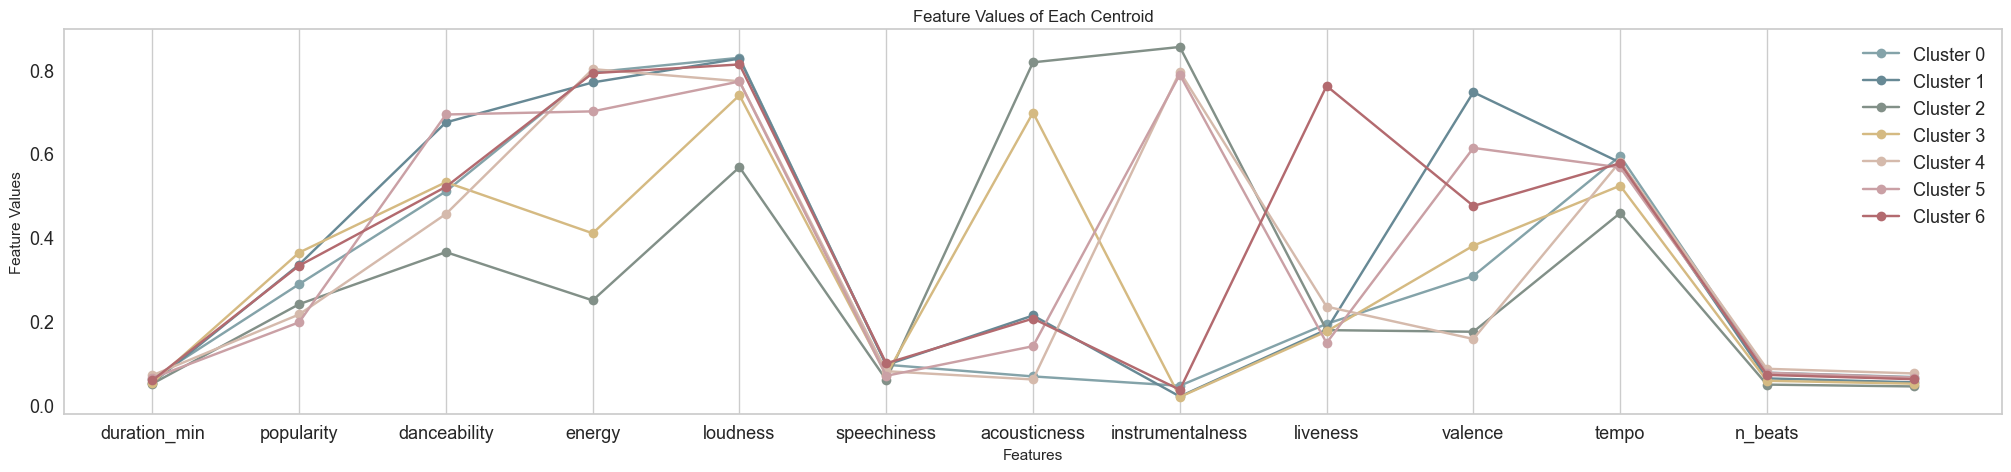

In [75]:
# kmeans linea plot
centers = kmeans.cluster_centers_

# Names of the clusters for legend
cluster_names = ['0', '1', '2', '3', '4', '5','6']

# the feature names
features = df_train.columns[:-1]

# Create the plot
color_list = ['#84A3A9', '#678995', '#829088', '#D5BA82', '#D5BAAC', '#CAA0A5', '#B36A6F']
plt.figure(figsize=(25, 5))
for i, center in enumerate(centers):
    plt.plot(center, marker='o', label=f'Cluster {cluster_names[i]}', color = color_list[i])

# Setting x-axis labels
plt.xticks(range(len(features)), features, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=13, loc='best')
plt.grid(axis='y')

plt.title('Feature Values of Each Centroid')
plt.xlabel('Features')
plt.ylabel('Feature Values')

plt.show()

In [17]:
cols = ['energy', 'acousticness', 'loudness', 'instrumentalness', 'valence']
df_new = df[cols]

kmeans = KMeans(n_clusters=7, n_init=10, max_iter=100)
kmeans.fit(df_new)

hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(df_new, kmeans.labels_))

labels {0: 2008, 1: 3139, 2: 1913, 3: 1671, 4: 1907, 5: 1199, 6: 3163}
sse 1354.692281963649
silhouette 0.3301390281272509


In [13]:
cols = ['energy', 'acousticness', 'loudness', 'instrumentalness', 'valence']
df_new = df[cols]

In [14]:
df_new

energy  acousticness  loudness  instrumentalness  valence
0       0.513      0.302000  0.702298          0.536000   0.6350
1       0.196      0.283000  0.469376          0.934000   0.0336
2       0.854      0.000089  0.798793          0.800000   0.4890
3       0.585      0.066400  0.833678          0.001270   0.3850
4       0.687      0.000576  0.724866          0.096900   0.6370
...       ...           ...       ...               ...      ...
14995   0.657      0.016000  0.669976          0.615000   0.0335
14996   0.860      0.548000  0.567578          0.940000   0.0016
14997   0.535      0.001830  0.767324          0.857000   0.0708
14998   0.970      0.000337  0.896464          0.000014   0.2700
14999   0.518      0.463000  0.792245          0.000000   0.7840

[15000 rows x 5 columns]

/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/shtk/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

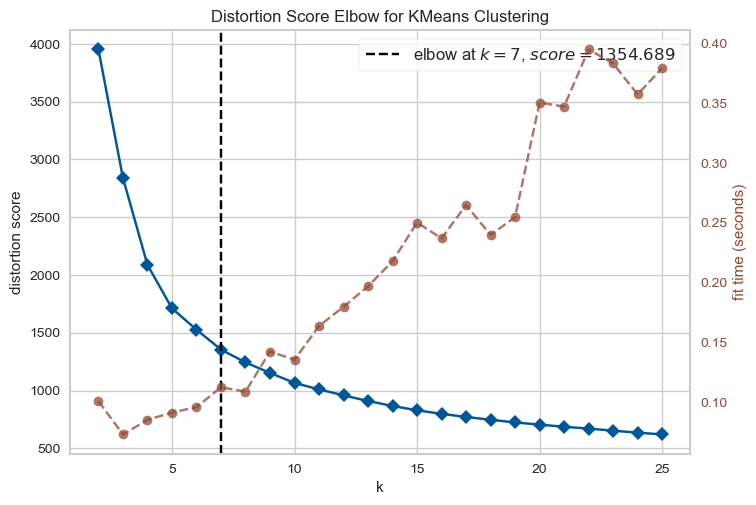

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [121]:
#cols = ['energy', 'acousticness', 'instrumentalness', 'valence', 'danceability', 'liveness']
colors = ['#934833', '#015697', 'black']

model = KMeans(random_state=0)
plot = KElbowVisualizer(model, k=(2,26))

for i, el in enumerate(plot.colors):
    plot.colors[el] = colors[i]

plot.fit(df_new)        # Fit the data to the visualizer


fig = KElbowVisualizer.fig
ax = KElbowVisualizer.ax
    
plot.show()

In [122]:
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=100)
kmeans.fit(df_new)

hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(df_new, kmeans.labels_))

labels {0: 3146, 1: 1671, 2: 2011, 3: 3135, 4: 1929, 5: 1197, 6: 1911}
sse 1354.6945827810664
silhouette 0.3301028585847988


## bisecting

In [8]:
from sklearn.cluster import BisectingKMeans

In [13]:
%%time

n_clusters = range(2, 26)
b_sse = []
b_silhouette = []
for n in tqdm(n_clusters):
    bkmeans = BisectingKMeans(n_clusters=n, n_init=10, max_iter=100)
    bkmeans.fit(df_train)
    b_sse.append(bkmeans.inertia_)
    b_silhouette.append(silhouette_score(df_train, bkmeans.labels_))

100%|███████████████████████████████████████████| 24/24 [00:46<00:00,  1.95s/it]

CPU times: user 2min 29s, sys: 1min 24s, total: 3min 54s
Wall time: 46.9 s


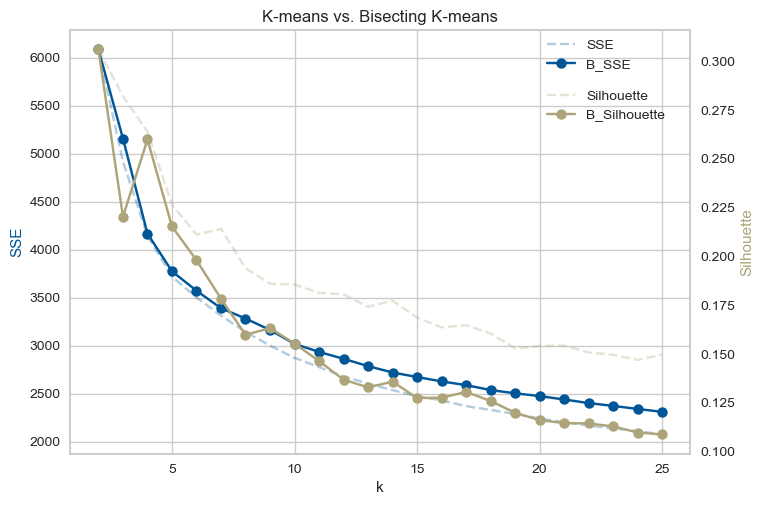

In [15]:
#colors = ['#ada579', '#6f8278', '#934833', '#050202']
colors = ['#015697', '#ada579']
fig, ax1 = plt.subplots()




ax1.plot(range(2, len(sse)+2), sse, color=colors[-2], label='SSE', alpha = 0.3, markersize = 15,linestyle = 'dashed')
ax1.plot(range(2, len(b_sse)+2), b_sse, color=colors[-2], marker='.', markersize = 15, label='B_SSE')
ax1.set_xlabel('k')
ax1.set_ylabel('SSE', color=colors[-2])


ax2 = ax1.twinx()


ax2.plot(range(2, len(sse)+2), silhouette, color=colors[1],label='Silhouette', markersize = 15, alpha = 0.3, linestyle = 'dashed')
ax2.plot(range(2, len(sse)+2), b_silhouette, color=colors[1], marker='.', markersize = 15, label='B_Silhouette')
ax2.set_ylabel('Silhouette', color=colors[1])

ax1.legend(loc=(0.76,0.89))
ax2.legend(loc=(0.76,0.77))

ax2.grid(axis='y')

plt.title('K-means vs. Bisecting K-means')
plt.show()

In [41]:
bkmeans = BisectingKMeans(n_clusters=7, n_init=10, max_iter=100)
bkmeans.fit(df_train)
print('SSE', bkmeans.inertia_)
print('Silhouette', silhouette_score(df_train, bkmeans.labels_))

hist, bins = np.histogram(bkmeans.labels_, bins=range(0, len(set(bkmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
# even worse

SSE 3389.9198094104813
Silhouette 0.1783026555004044
labels {0: 1824, 1: 1381, 2: 3771, 3: 3186, 4: 1841, 5: 1626, 6: 1371}


### Kmeans with reduced attributes

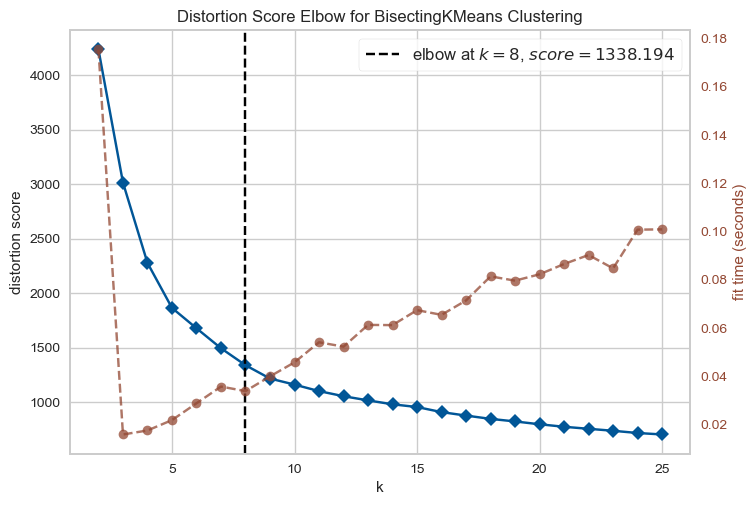

<AxesSubplot:title={'center':'Distortion Score Elbow for BisectingKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
cols = ['energy', 'acousticness', 'loudness', 'instrumentalness', 'valence']
df_new = df[cols]


#cols = ['energy', 'acousticness', 'instrumentalness', 'valence', 'danceability', 'liveness']
colors = ['#934833', '#015697', 'black']

model = KMeans(random_state=0)
plot = KElbowVisualizer(model, k=(2,26))

for i, el in enumerate(plot.colors):
    plot.colors[el] = colors[i]

plot.fit(df_new)        # Fit the data to the visualizer


fig = KElbowVisualizer.fig
ax = KElbowVisualizer.ax
    
plot.show()


In [11]:
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=100)
kmeans.fit(df_new)

hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(df_new, kmeans.labels_))

labels {0: 1347, 1: 1825, 2: 3751, 3: 3253, 4: 1942, 5: 1067, 6: 1815}
sse 1421.1479800608893
silhouette 0.30972204361392974


## DBScan

In [6]:
def kth_distance(k, dist):
    kth_distances = []
    for d in dist: 
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])
    return kth_distances

def plot_kth_distance(k_list, dist, color):
    fig, axes = plt.subplots(1, len(k_list), figsize=(30, 5))
    for i, k in enumerate(k_list):
        kth_distances = kth_distance(k, dist)

        ax = axes[i]
        ax.plot(range(0, len(kth_distances)), sorted(kth_distances), color = color)
        if k == 3:
            ax.set_ylabel('distance from the {}rd neighbor'.format(k))
        else:
            ax.set_ylabel('distance from the {}th neighbor'.format(k))

    plt.show()
    
def eval_dbscan(k_list, eps_l, dist, train):
    for i, eps in enumerate(eps_l):
        dbscan = DBSCAN(eps=eps, min_samples=k_list[i], metric='precomputed').fit(dist)
        hist, bins = np.histogram(dbscan.labels_, bins=range(0, len(set(dbscan.labels_)) + 1))
        print(f'Silhouette with eps = {eps}, min_samples = {k_list[i]}', silhouette_score(train, dbscan.labels_))
        dic = dict(zip(bins, hist))
        dic[-1] = np.sum(dbscan.labels_ == -1)
        print('labels', dic)

In [7]:
dist = squareform(pdist(df_train, 'euclidean')); dist

array([[0.        , 1.18347732, 0.80114715, ..., 0.76402079, 0.90697586,
        0.67761061],
       [1.18347732, 0.        , 0.99043523, ..., 1.08161227, 1.51426054,
        1.50983427],
       [0.80114715, 0.99043523, 0.        , ..., 0.83186172, 0.96118675,
        1.15288638],
       ...,
       [0.76402079, 1.08161227, 0.83186172, ..., 0.        , 1.09816494,
        1.23265771],
       [0.90697586, 1.51426054, 0.96118675, ..., 1.09816494, 0.        ,
        0.96370412],
       [0.67761061, 1.50983427, 1.15288638, ..., 1.23265771, 0.96370412,
        0.        ]])

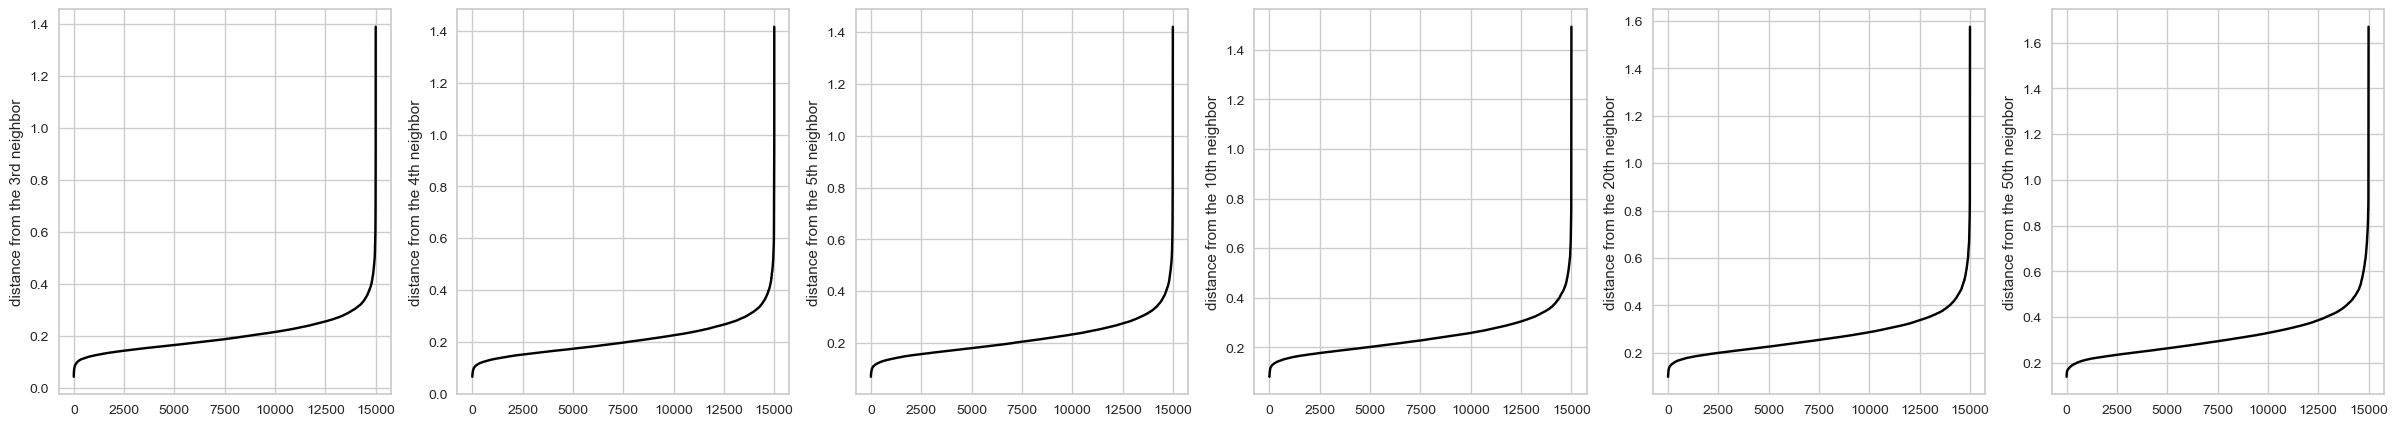

In [23]:
k_list = [3, 4, 5, 10, 20, 50]

pddlot_kth_distance(k_list, dist, '#050202')

In [29]:
k_list = [3, 4, 5, 10, 20, 50]
eps_l = [0.45, 0.5, 0.55, 0.6, 0.65, 0.8]
eval_dbscan(k_list, eps_l, dist, df_train)

Silhouette with eps = 0.45, min_samples = 3 0.19712290261805768
labels {0: 14950, 1: 3, 2: 4, 3: 0, -1: 43}
Silhouette with eps = 0.5, min_samples = 4 0.25460942271462295
labels {0: 14976, 1: 4, 2: 0, -1: 20}
Silhouette with eps = 0.55, min_samples = 5 0.3411320865002694
labels {0: 14984, 1: 0, -1: 16}
Silhouette with eps = 0.6, min_samples = 10 0.36454107488508236
labels {0: 14990, 1: 0, -1: 10}
Silhouette with eps = 0.65, min_samples = 20 0.36454107488508236
labels {0: 14990, 1: 0, -1: 10}
Silhouette with eps = 0.8, min_samples = 50 0.3860616984975066
labels {0: 14993, 1: 0, -1: 7}


### OPTICS

In [7]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

In [8]:
k_optics = [5, 10, 15, 20, 50, 75]

In [6]:
reachabilities = []
for k in k_optics:
    optics = OPTICS(min_samples = k, max_eps = np.inf)
    optics.fit(df_train)
    hist, bins = np.histogram(optics.labels_, bins=range(0, len(set(optics.labels_)) + 1))
    dic = dict(zip(bins, hist))
    dic[-1] = np.sum(optics.labels_ == -1)
    
    reachability = optics.reachability_[optics.ordering_]
    reachabilities.append(reachability)
    
    if list(np.unique(optics.labels_)) == [0] or list(np.unique(optics.labels_))==[-1, 0]:
        print('only 1 class' )
    else:
        print(f"Silhouette with {k} min_samples: {silhouette_score(df_train[optics.labels_ != -1], optics.labels_[optics.labels_ != -1])}" )
        print('labels', dic)

Silhouette with 5 min_samples: 0.4379472478966307
labels {0: 5, 1: 7, 2: 6, 3: 5, 4: 6, 5: 6, 6: 7, 7: 12, 8: 5, 9: 5, 10: 10, 11: 7, 12: 5, 13: 12, 14: 8, 15: 7, 16: 5, 17: 6, 18: 5, 19: 5, 20: 10, 21: 11, 22: 7, 23: 7, 24: 5, 25: 7, 26: 8, 27: 5, 28: 6, 29: 5, 30: 7, 31: 5, 32: 5, 33: 6, 34: 5, 35: 7, 36: 5, 37: 7, 38: 5, 39: 5, 40: 6, 41: 8, 42: 11, 43: 5, 44: 8, 45: 5, 46: 12, 47: 5, 48: 6, 49: 5, 50: 7, 51: 6, 52: 6, 53: 7, 54: 5, 55: 6, 56: 8, 57: 5, 58: 5, 59: 7, 60: 5, 61: 12, 62: 5, 63: 5, 64: 10, 65: 5, 66: 6, 67: 5, 68: 5, 69: 7, 70: 8, 71: 5, 72: 6, 73: 10, 74: 5, 75: 7, 76: 5, 77: 5, 78: 9, 79: 5, 80: 8, 81: 6, 82: 5, 83: 5, 84: 8, 85: 13, 86: 7, 87: 7, 88: 9, 89: 10, 90: 8, 91: 9, 92: 7, 93: 6, 94: 5, 95: 8, 96: 5, 97: 11, 98: 5, 99: 6, 100: 8, 101: 7, 102: 5, 103: 18, 104: 7, 105: 6, 106: 9, 107: 7, 108: 7, 109: 9, 110: 6, 111: 5, 112: 6, 113: 12, 114: 8, 115: 7, 116: 10, 117: 8, 118: 12, 119: 7, 120: 10, 121: 7, 122: 8, 123: 0, -1: 14138}
Silhouette with 10 min_samples:

In [31]:
colors = np.array([(64, 128, 148),  (119, 165, 179), (215, 230, 234), (237, 204, 197), (222, 160, 145), (198, 91, 63)])/255

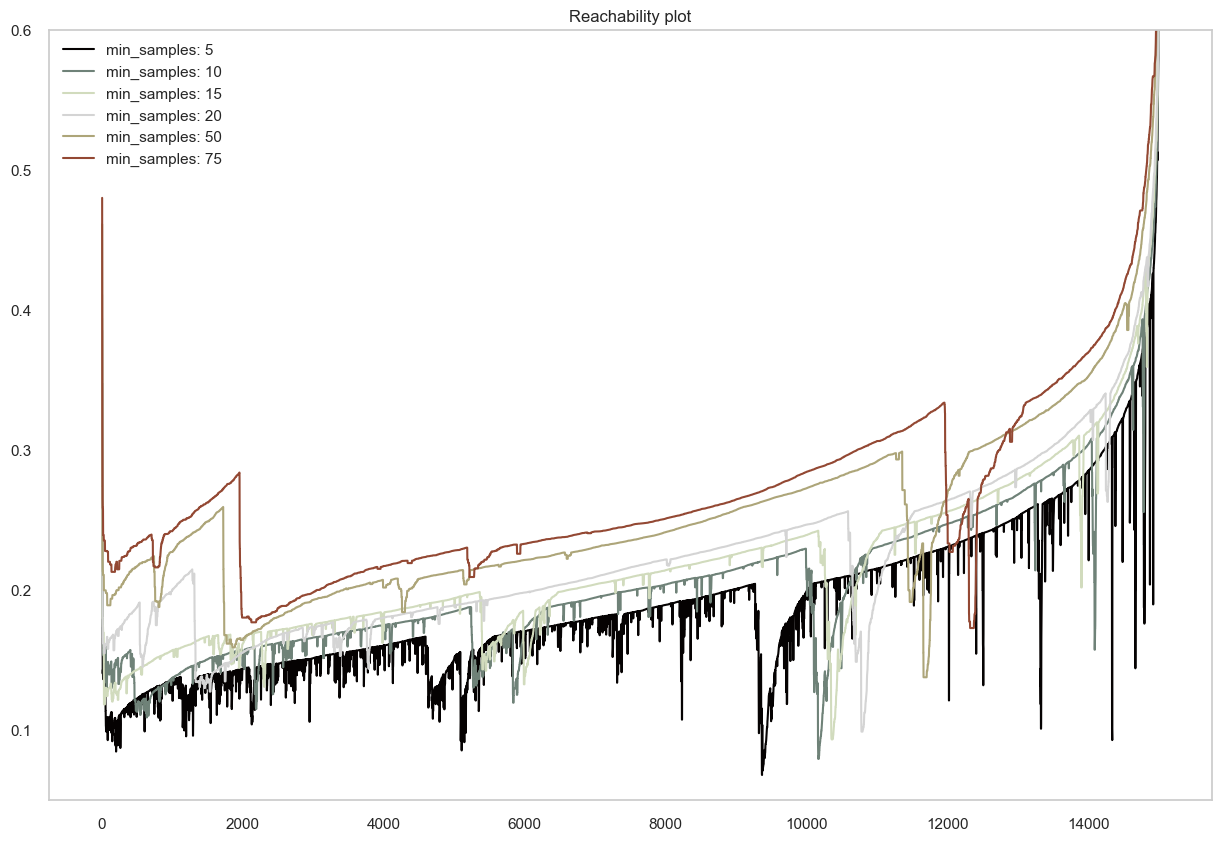

In [30]:
# Generate reachability plot
sns.set_theme(style="whitegrid")
colors = ['#050202', '#6f8278', '#d1dbbd', '#d4d4d4', '#ada579', '#934833']

plt.figure(figsize = (15, 10))

for i, r in enumerate(reachabilities):
    plt.plot(r, label=f'min_samples: {k_optics[i]}', color = colors[i])

plt.ylim(0.05, 0.6)
plt.title('Reachability plot')
plt.grid(False)
plt.legend(loc = 'best')
plt.show()

## Hierarchical

In [8]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)
    plt.grid(False)


In [9]:
def sil_hier(train, k_list, **kwargs):
    sil_list = []
    for i in k_list:
        model = AgglomerativeClustering(n_clusters=i, **kwargs).fit(train)
        sil = silhouette_score(train, model.labels_)
        print("n_cluster:", i, 'silhouette score:', sil) 
        sil_list.append(sil)
        
        hist, bins = np.histogram(model.labels_, bins=range(0, len(set(model.labels_)) + 1))                   
        print('cluster_size:', dict(zip(bins, hist)))
        
    return sil_list

In [10]:
# 2x2 dendograms for each method applied
def multi_dendrogram(train, methods, **kwargs):
    pos = [[0, 0], [0, 1], [1, 0], [1, 1]]
    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    
    for i, method in enumerate(methods):
        model = AgglomerativeClustering(linkage=method, **kwargs).fit(train)
        ax = axes[pos[i][0], pos[i][1]]
        plot_dendrogram(model, ax=ax, truncate_mode='lastp')
        ax.set_title(method, fontsize=16)
        ax.grid(False) 
    
    if len(methods) < 4:
        for j in range(len(methods), 4):
            fig.delaxes(axes.flatten()[j])

    plt.grid(False)
    plt.show()    

In [11]:
methods = ['single', 'complete', 'average', "ward"]

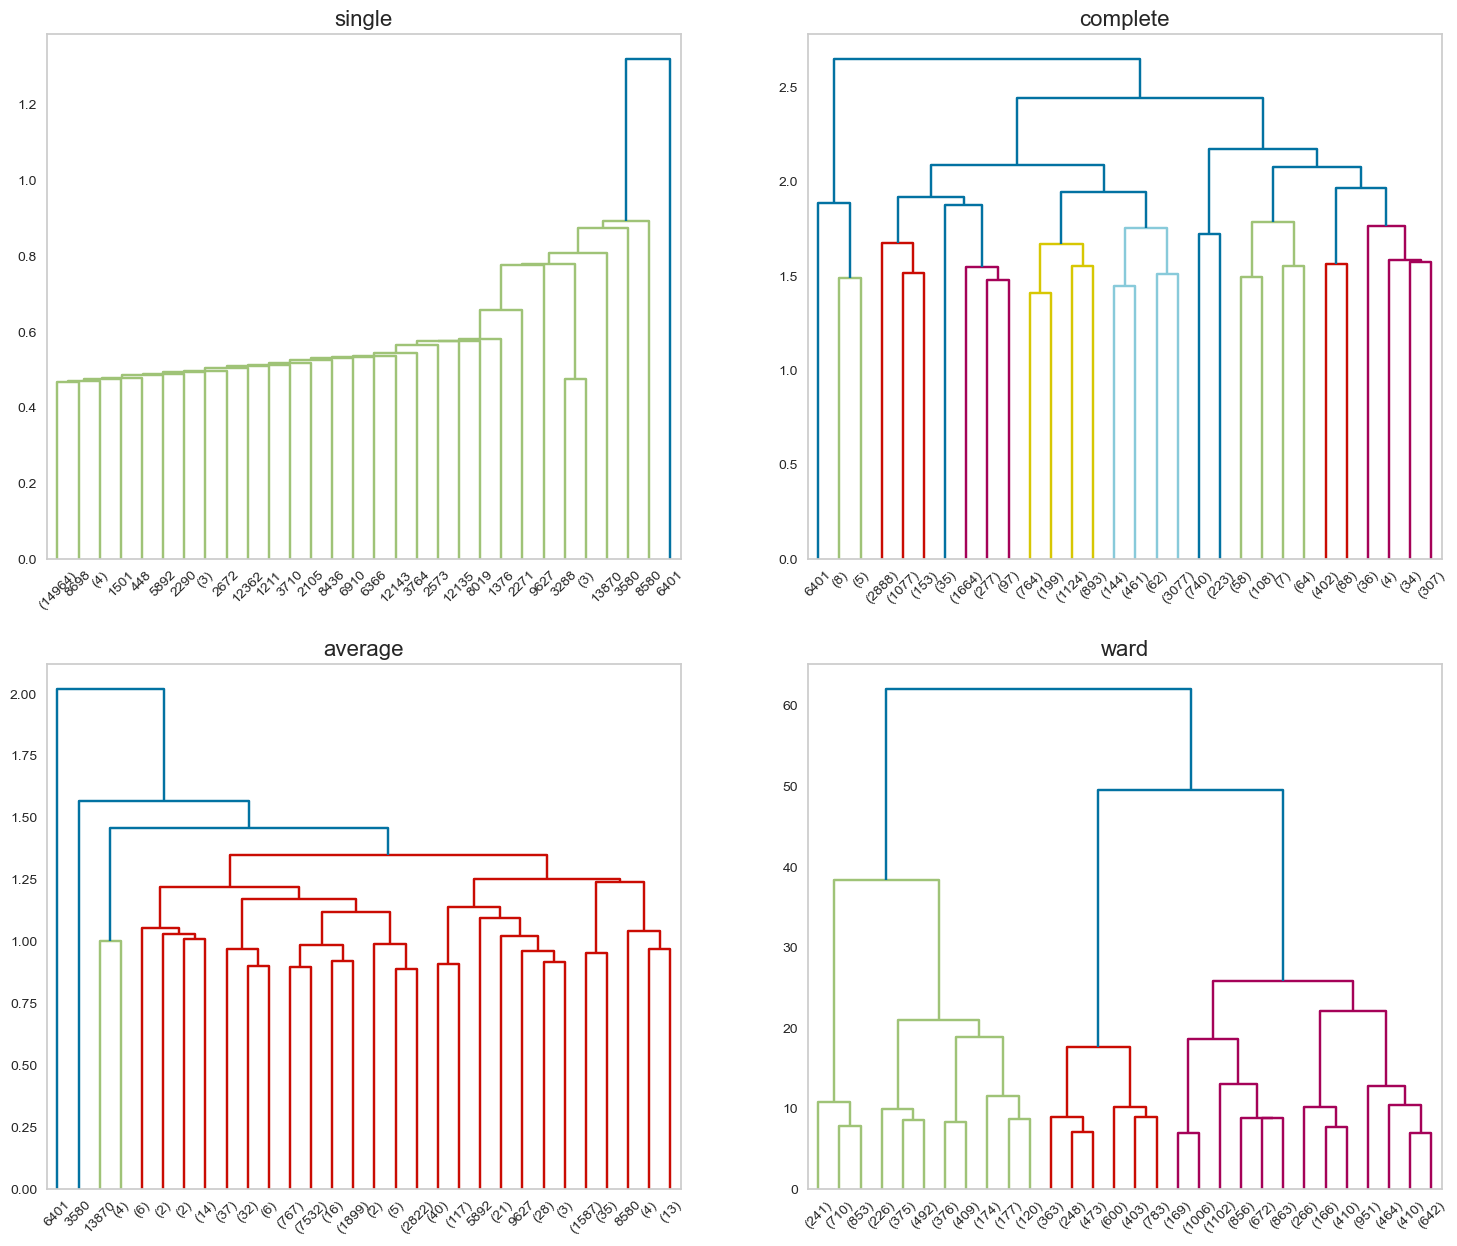

In [67]:
multi_dendrogram(df_train, methods, distance_threshold=0, n_clusters=None, metric='euclidean')

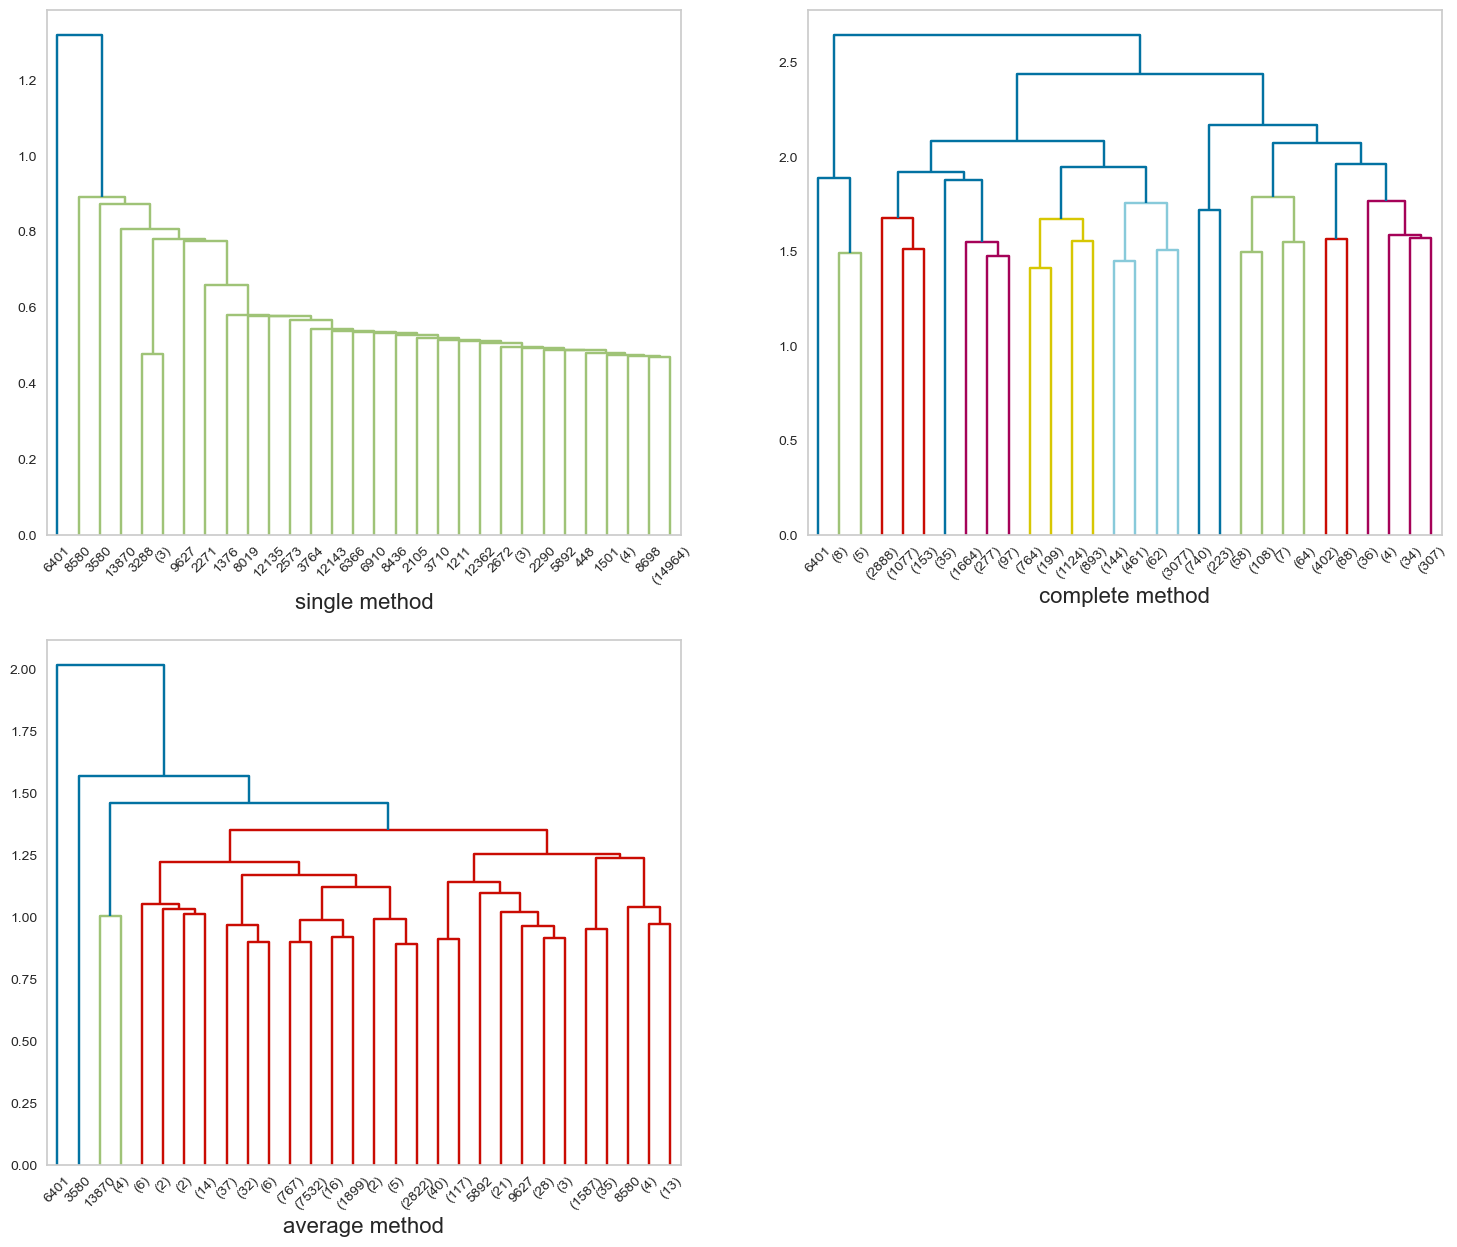

In [19]:
# precomputed
multi_dendrogram(dist, methods[:-1], distance_threshold=0, n_clusters=None, metric='precomputed')

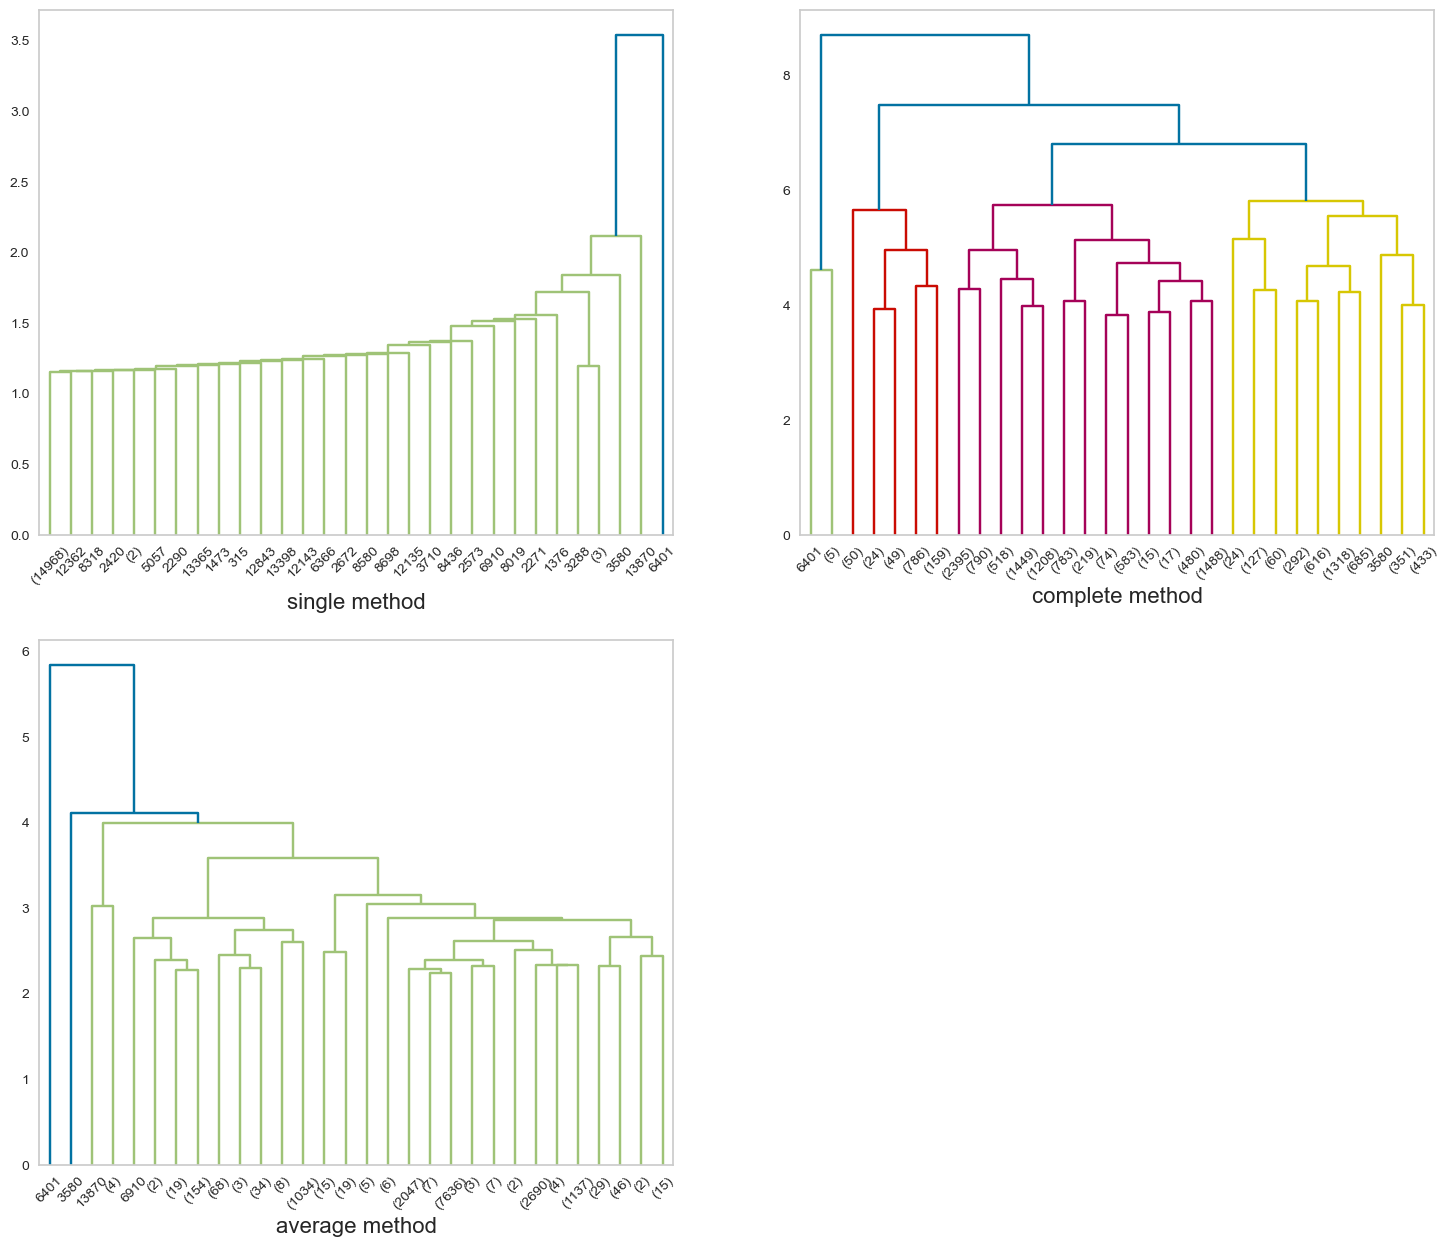

In [87]:
# manhattan
multi_dendrogram(df_train, methods[:-1], distance_threshold=0, n_clusters=None, metric='manhattan')

### evaluation

#### euclidean

In [14]:
k_list = [2, 3, 4, 5]
sil_list = []

for i, method in enumerate(methods):
    print(f'-- {method} --')
    sil = sil_hier(df_train, k_list, metric='euclidean', linkage=method)
    sil_list.append(sil)

-- single --
n_cluster: 2 silhouette score: 0.49996564217507916
cluster_size: {0: 14999, 1: 1}
n_cluster: 3 silhouette score: 0.4074327141609438
cluster_size: {0: 14998, 1: 1, 2: 1}
n_cluster: 4 silhouette score: 0.32542153204101826
cluster_size: {0: 14997, 1: 1, 2: 1, 3: 1}
n_cluster: 5 silhouette score: 0.24328849494939672
cluster_size: {0: 14996, 1: 1, 2: 1, 3: 1, 4: 1}
-- complete --
n_cluster: 2 silhouette score: 0.2574881789979038
cluster_size: {0: 14986, 1: 14}
n_cluster: 3 silhouette score: 0.2751961388065729
cluster_size: {0: 2071, 1: 14, 2: 12915}
n_cluster: 4 silhouette score: 0.22795541991419416
cluster_size: {0: 12915, 1: 14, 2: 1108, 3: 963}
n_cluster: 5 silhouette score: 0.1283765684708937
cluster_size: {0: 1108, 1: 6191, 2: 6724, 3: 963, 4: 14}
-- average --
n_cluster: 2 silhouette score: 0.49996564217507916
cluster_size: {0: 14999, 1: 1}
n_cluster: 3 silhouette score: 0.34936926667204754
cluster_size: {0: 14998, 1: 1, 2: 1}
n_cluster: 4 silhouette score: 0.267009670736

#### manhattan

In [15]:
k_list = [2, 3, 4, 5]
sil_list_man = []

for i, method in enumerate(methods[:-1]):
    print(f'-- {method} --')
    sil = sil_hier(df_train, k_list, metric='manhattan', linkage=method)
    sil_list_man.append(sil)

-- single --
n_cluster: 2 silhouette score: 0.49996564217507916
cluster_size: {0: 14999, 1: 1}
n_cluster: 3 silhouette score: 0.2836969253962036
cluster_size: {0: 14998, 1: 1, 2: 1}
n_cluster: 4 silhouette score: 0.2552931780844526
cluster_size: {0: 14997, 1: 1, 2: 1, 3: 1}
n_cluster: 5 silhouette score: 0.2372204186156118
cluster_size: {0: 14993, 1: 4, 2: 1, 3: 1, 4: 1}
-- complete --
n_cluster: 2 silhouette score: 0.3555141603754686
cluster_size: {0: 14994, 1: 6}
n_cluster: 3 silhouette score: 0.2995747992969655
cluster_size: {0: 13926, 1: 6, 2: 1068}
n_cluster: 4 silhouette score: 0.2735596141918821
cluster_size: {0: 3907, 1: 10019, 2: 1068, 3: 6}
n_cluster: 5 silhouette score: 0.25951876570094656
cluster_size: {0: 10019, 1: 3696, 2: 1068, 3: 6, 4: 211}
-- average --
n_cluster: 2 silhouette score: 0.49996564217507916
cluster_size: {0: 14999, 1: 1}
n_cluster: 3 silhouette score: 0.34936926667204754
cluster_size: {0: 14998, 1: 1, 2: 1}
n_cluster: 4 silhouette score: 0.2670096707369275

#### precomputed

In [20]:
k_list = [2, 3, 4, 5]
sil_list_pre = []

for i, method in enumerate(methods[:-1]):
    print(f'-- {method} --')
    sil = sil_hier(dist, k_list, metric='precomputed', linkage=method)
    sil_list_pre.append(sil)

-- single --
n_cluster: 2 silhouette score: 0.6111031571490517
cluster_size: {0: 14999, 1: 1}
n_cluster: 3 silhouette score: 0.5103070560053433
cluster_size: {0: 14998, 1: 1, 2: 1}
n_cluster: 4 silhouette score: 0.371654842694283
cluster_size: {0: 14997, 1: 1, 2: 1, 3: 1}
n_cluster: 5 silhouette score: 0.20559727477259693
cluster_size: {0: 14996, 1: 1, 2: 1, 3: 1, 4: 1}
-- complete --
n_cluster: 2 silhouette score: 0.2236488864258
cluster_size: {0: 14986, 1: 14}
n_cluster: 3 silhouette score: 0.3339260033302448
cluster_size: {0: 2071, 1: 14, 2: 12915}
n_cluster: 4 silhouette score: 0.2899584551320436
cluster_size: {0: 12915, 1: 14, 2: 1108, 3: 963}
n_cluster: 5 silhouette score: 0.13126461705570389
cluster_size: {0: 1108, 1: 6191, 2: 6724, 3: 963, 4: 14}
-- average --
n_cluster: 2 silhouette score: 0.6111031571490517
cluster_size: {0: 14999, 1: 1}
n_cluster: 3 silhouette score: 0.37222627353747173
cluster_size: {0: 14998, 1: 1, 2: 1}
n_cluster: 4 silhouette score: 0.2641330919438954
cl

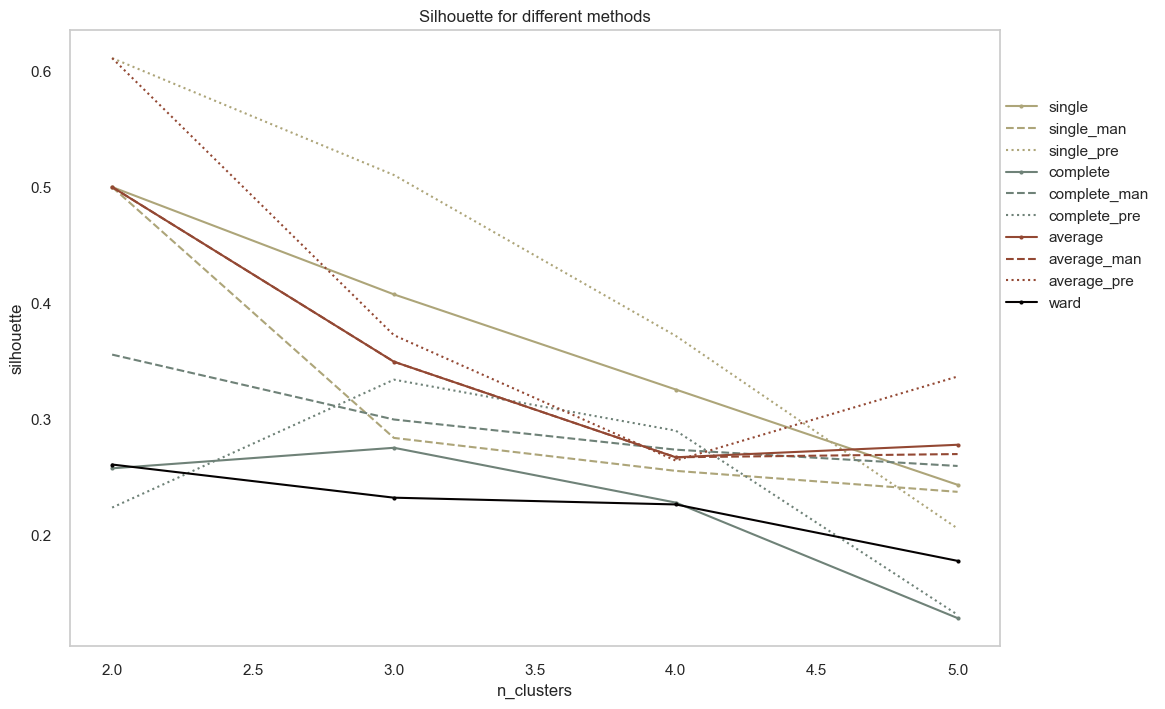

In [146]:
colors = ['#ada579', '#6f8278', '#934833', '#050202']

plt.figure(figsize = (12, 8))

for i, sil in enumerate(sil_list):
    # euclidean
    plt.plot(k_list, sil, marker='.', color = colors[i], label=methods[i])
    
    if i < 3:
        # manhattan
        plt.plot(k_list, sil_list_man[i], color = colors[i], linestyle='--', label=methods[i] + '_man')
        # precomputed
        plt.plot(k_list, sil_list_pre[i], color = colors[i], linestyle='dotted', marker='x',  label=methods[i] + '_pre')
    plt.xlabel('n_clusters')
    plt.ylabel('silhouette')
    plt.title('Silhouette for different methods')
    plt.legend(loc=(1, 0.535))
plt.grid(False)    
plt.show()

### hierarchical with reduced attributes

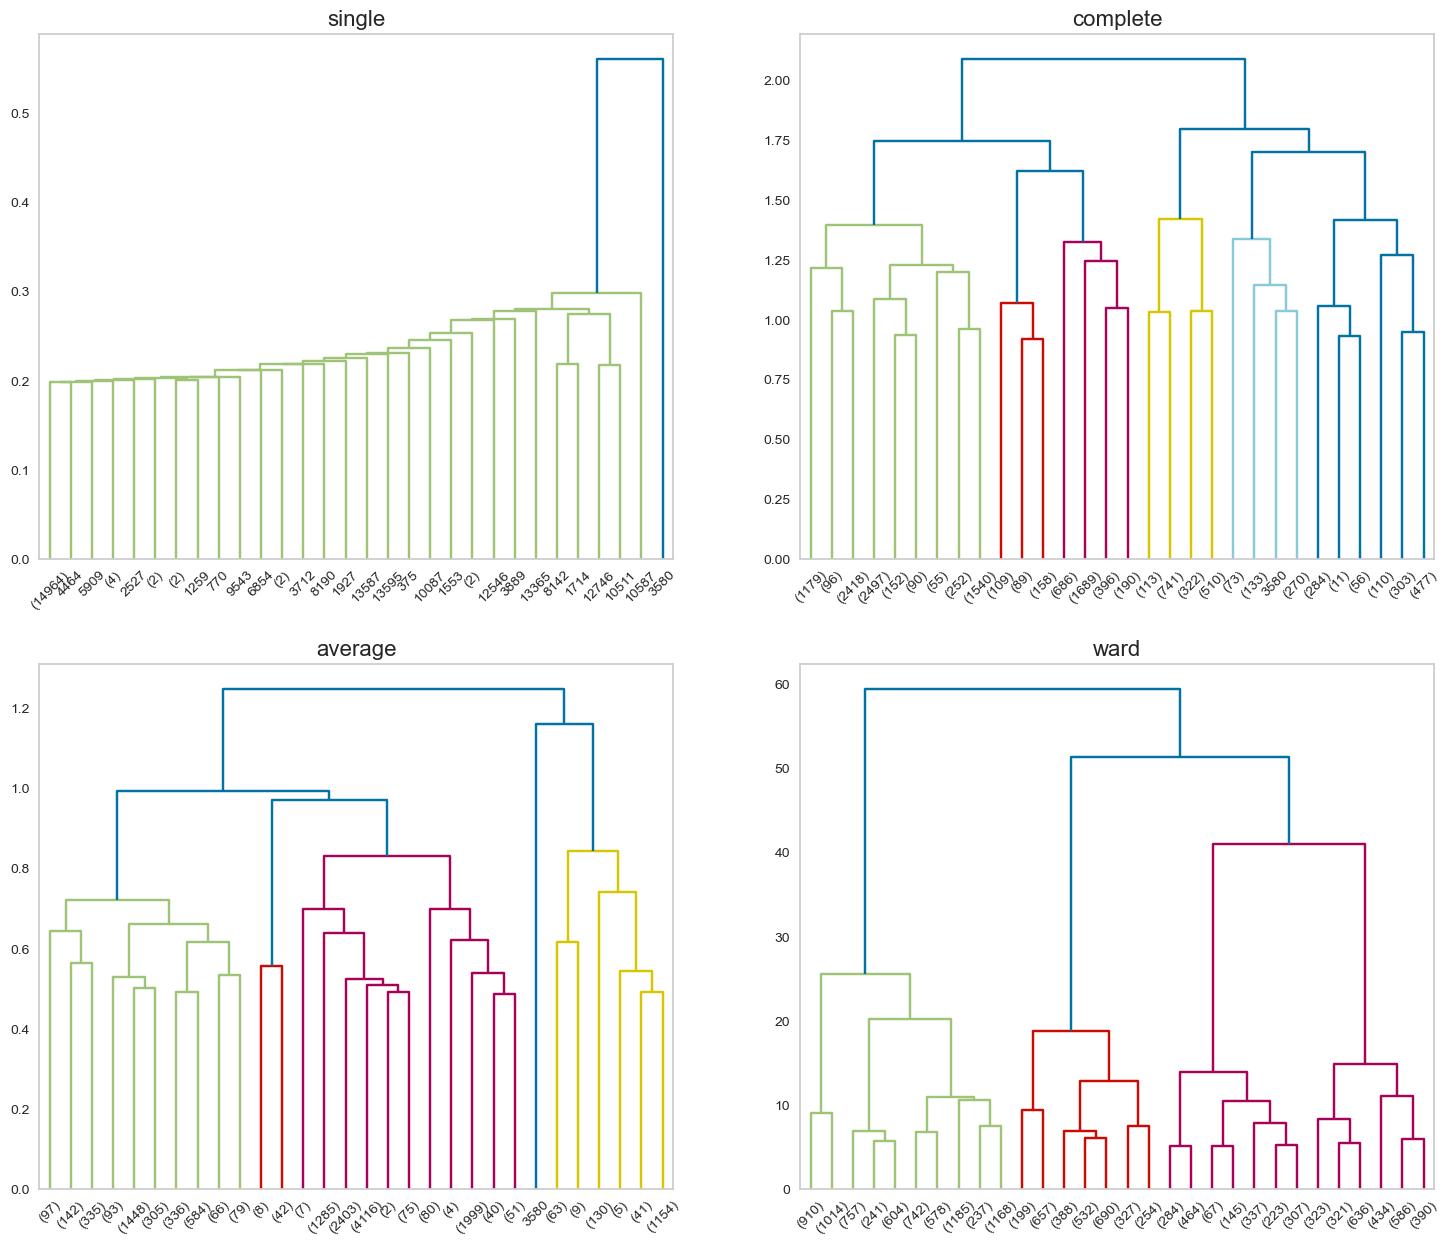

In [20]:
multi_dendrogram(df_new, methods, distance_threshold=0, n_clusters=None, metric='euclidean')

In [16]:
k_list = [2, 3, 4, 5]
sil_list = []

for i, method in enumerate(methods):
    print(f'-- {method} --')
    sil = sil_hier(df_new, k_list, metric='euclidean', linkage=method)
    sil_list.append(sil)

-- single --
n_cluster: 2 silhouette score: 0.34221744731560294
cluster_size: {0: 14999, 1: 1}
n_cluster: 3 silhouette score: 0.01261696883492386
cluster_size: {0: 14998, 1: 1, 2: 1}
n_cluster: 4 silhouette score: -0.018237049078849328
cluster_size: {0: 14994, 1: 4, 2: 1, 3: 1}
n_cluster: 5 silhouette score: -0.0579281369678148
cluster_size: {0: 4, 1: 14993, 2: 1, 3: 1, 4: 1}
-- complete --
n_cluster: 2 silhouette score: 0.32399207821699433
cluster_size: {0: 3404, 1: 11596}
n_cluster: 3 silhouette score: 0.2525060335467596
cluster_size: {0: 11596, 1: 1718, 2: 1686}
n_cluster: 4 silhouette score: 0.3350996628760939
cluster_size: {0: 1718, 1: 3317, 2: 1686, 3: 8279}
n_cluster: 5 silhouette score: 0.3204604742622289
cluster_size: {0: 3317, 1: 1241, 2: 1686, 3: 8279, 4: 477}
-- average --
n_cluster: 2 silhouette score: 0.3857146634396344
cluster_size: {0: 1403, 1: 13597}
n_cluster: 3 silhouette score: 0.3645260018338887
cluster_size: {0: 13597, 1: 1402, 2: 1}
n_cluster: 4 silhouette score:

## Compare of methods

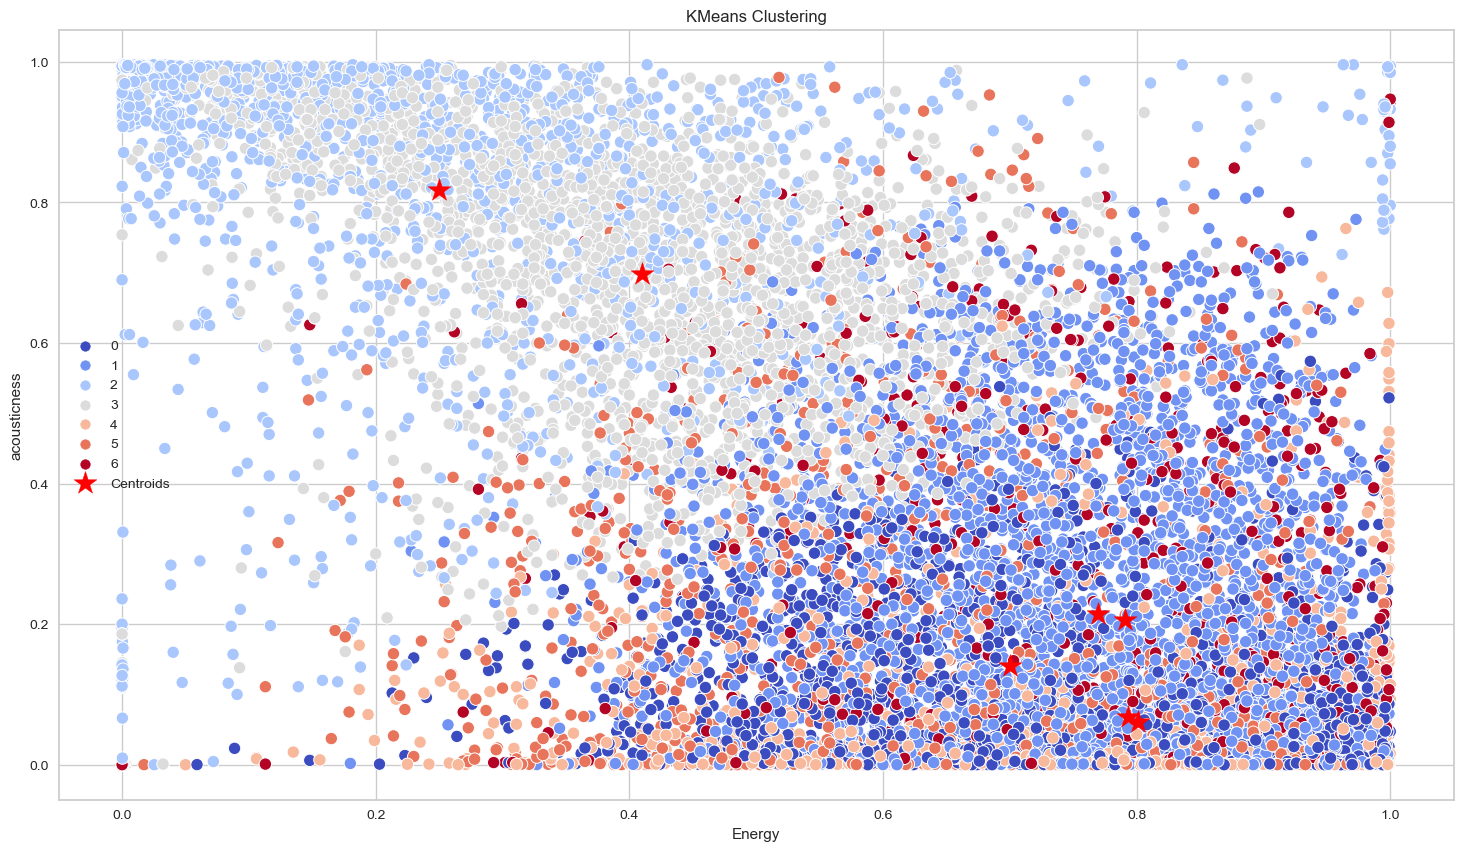

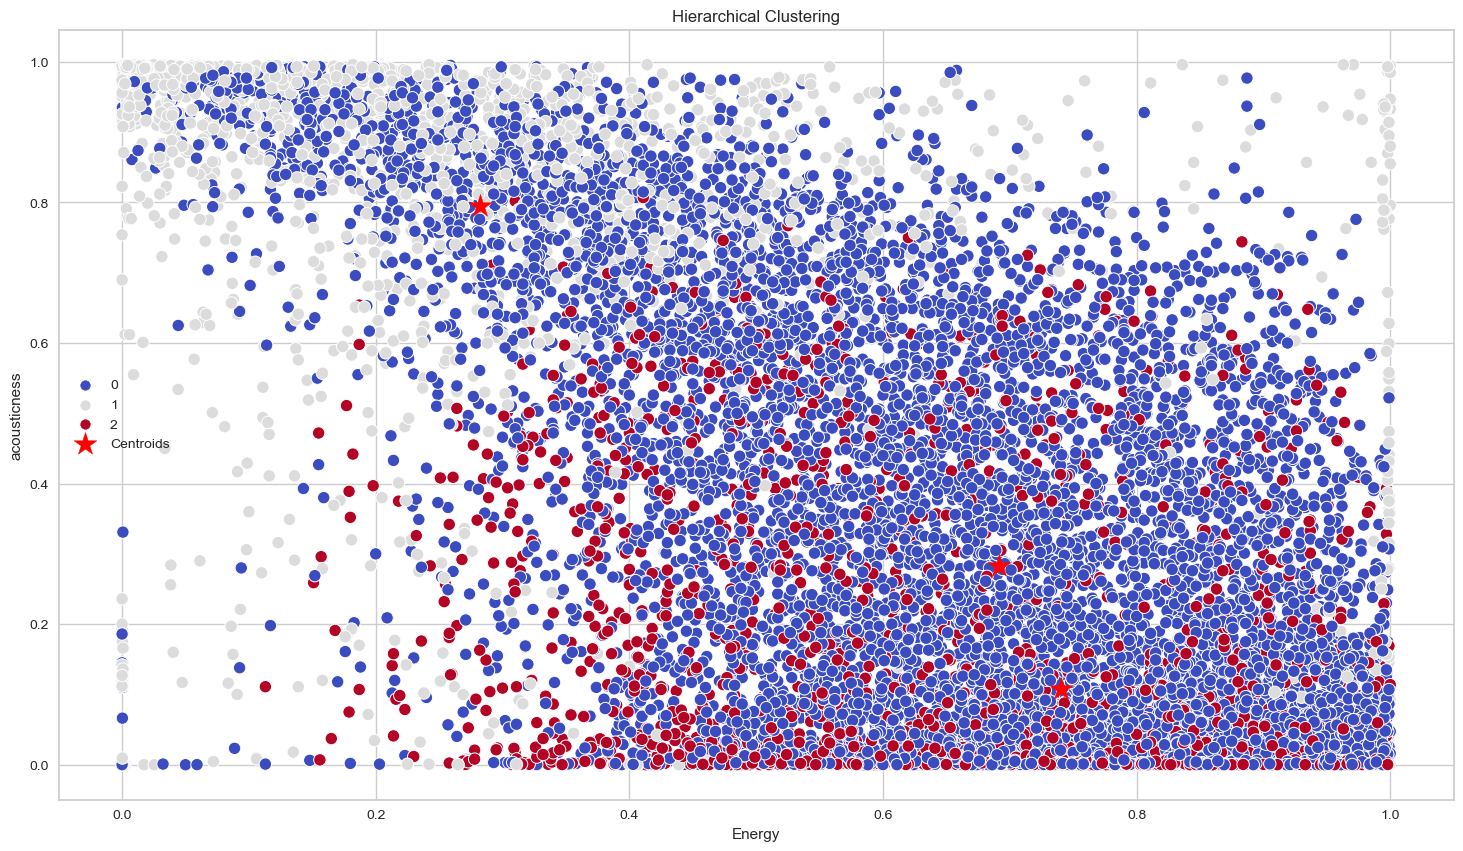

In [41]:
def plot_clusters(df, cluster_column, title):
    plt.figure(figsize=(18, 10))
    sns.scatterplot(data=df, x='energy', y='acousticness', hue=cluster_column, palette='coolwarm', s=80)
    centroids = df.groupby(cluster_column)[['energy', 'acousticness']].mean()
    plt.scatter(centroids['energy'], centroids['acousticness'], s=300, c='red', marker='*', label='Centroids')
    plt.title(title)
    plt.xlabel('Energy')
    plt.ylabel('acousticness')
    plt.legend()
    plt.show()

plot_clusters(df, 'KMeans_Cluster', 'KMeans Clustering')
plot_clusters(df, 'Hierarchical_Cluster', 'Hierarchical Clustering')

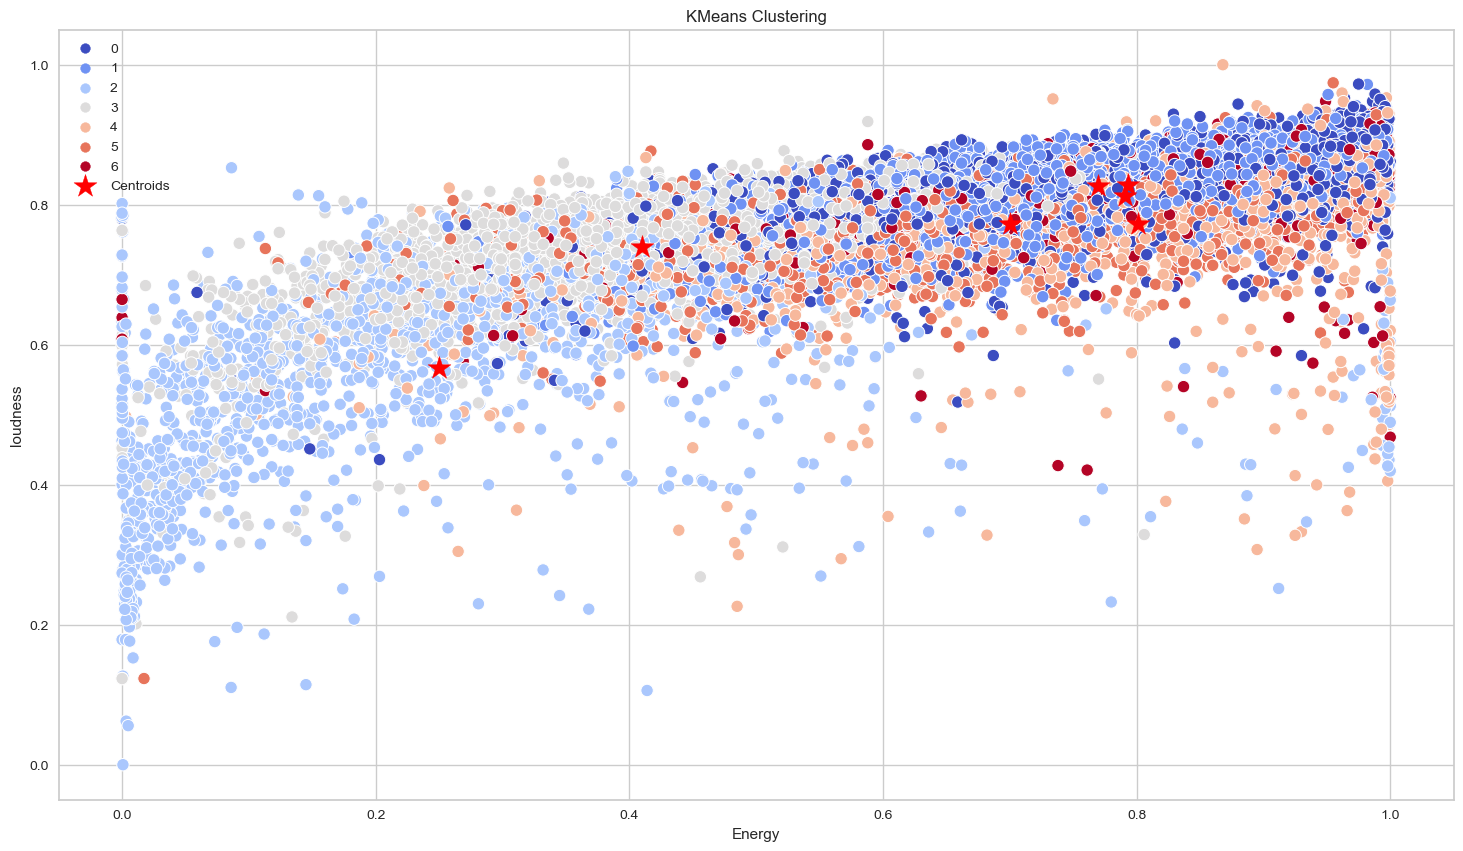

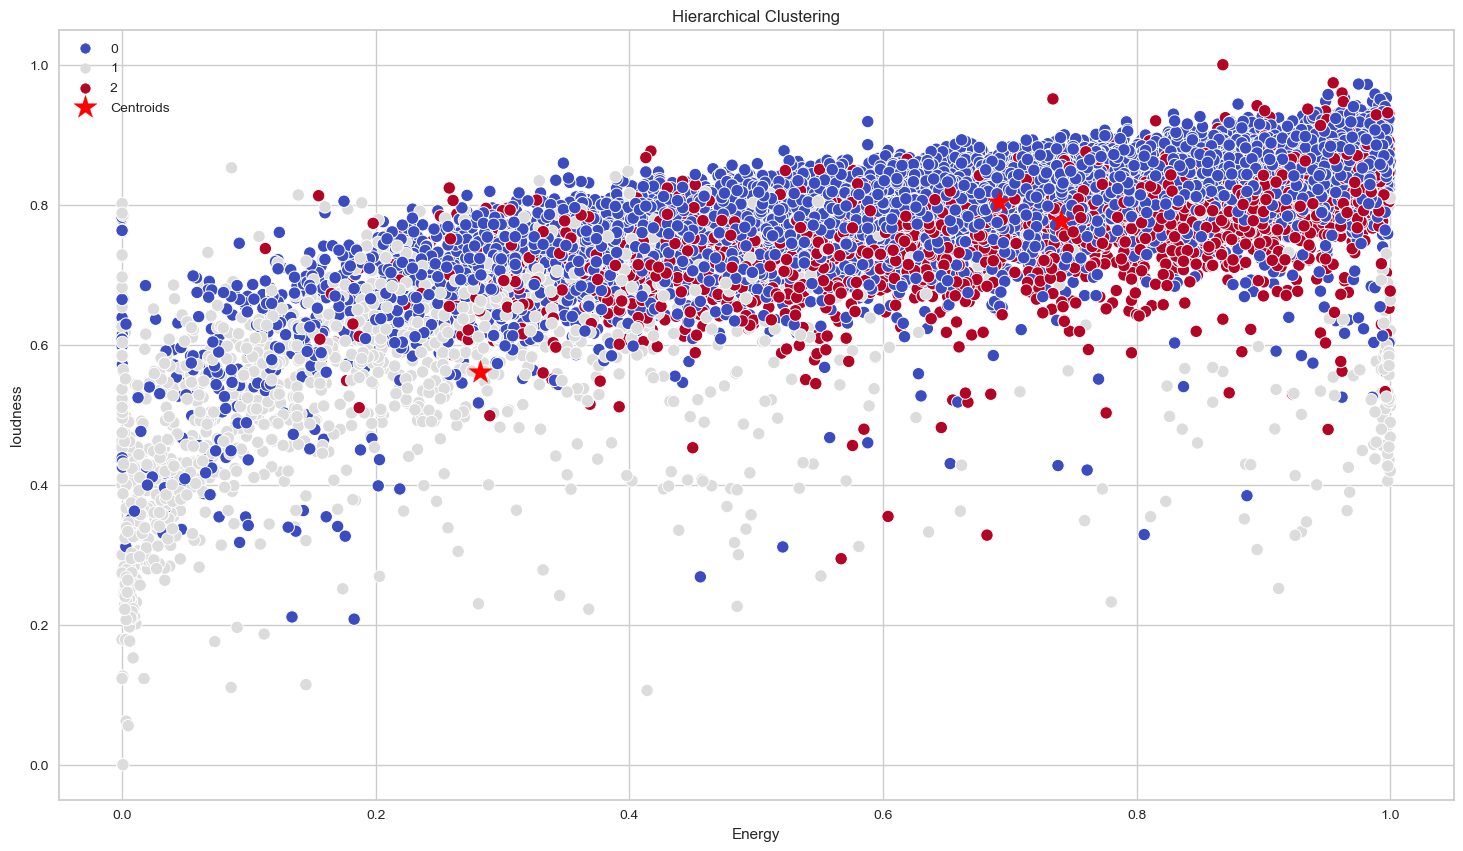

In [42]:
plot_clusters(df, 'KMeans_Cluster', 'KMeans Clustering')
plot_clusters(df, 'Hierarchical_Cluster', 'Hierarchical Clustering')

#### cluster distribution by attributes

In [56]:
cols = ['energy', 'acousticness', 'loudness', 'instrumentalness', 'valence']
df_new = df[cols]
 
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=100)
kmeans.fit(df_new)
 
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(df_new, kmeans.labels_))
 

labels {0: 2006, 1: 1907, 2: 3163, 3: 1672, 4: 1913, 5: 3139, 6: 1200}
sse 1354.6998234782707
silhouette 0.3300342430355647


KMeans Cluster Distribution:
 KMeans_Cluster
0    3161
3    3141
1    2015
4    1911
6    1909
2    1672
5    1191
Name: count, dtype: int64


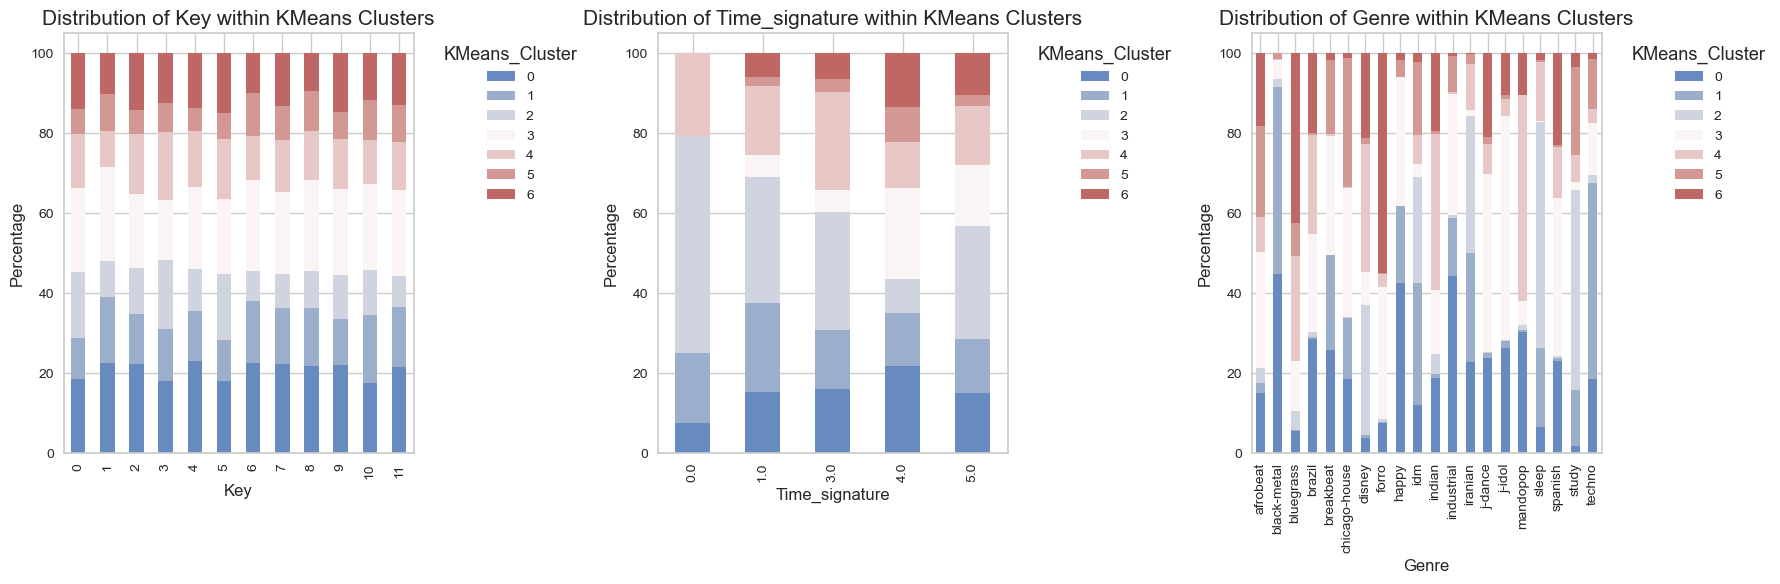

In [72]:
# Creating columns to store the clustering results
df['KMeans_Cluster'] = np.nan

# Using KMeans for clustering
kmeans = KMeans(n_clusters=7, n_init=10, max_iter=100, random_state=123)
kmeans.fit(df_new) 
labels = kmeans.labels_
df['KMeans_Cluster'] = labels

# Check the cluster distribution
print("KMeans Cluster Distribution:\n", df['KMeans_Cluster'].value_counts())

# Function to create a crosstab of cluster percentages
def create_crosstab_percentage(cluster_col, feature_col):
    crosstab = pd.crosstab(df[feature_col], df[cluster_col], normalize='index') * 100
    return crosstab

# Function to plot a stacked percentage bar chart
def plot_stacked_percentage_bar(ax, data, title, xlabel, ylabel, legend_title):
    colors = sns.color_palette('vlag', n_colors=len(data.columns))
    data.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', title_fontsize='13')
    ax.tick_params(axis='x', rotation=90)

# Clustering methods and features to plot
methods = ['KMeans_Cluster']
features = ['key', 'time_signature', 'genre']

# Creating a subplot layout for the charts

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the distribution of each cluster within each method

for i, feature in enumerate(features):
    ax = axes[i]
    crosstab_percentage = create_crosstab_percentage('KMeans_Cluster', feature)
    plot_stacked_percentage_bar(ax, crosstab_percentage, f'Distribution of {feature.capitalize()} within KMeans Clusters', feature.capitalize(), 'Percentage', 'KMeans_Cluster')

plt.tight_layout()
plt.show()


/Users/yian/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/yian/anaconda3/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


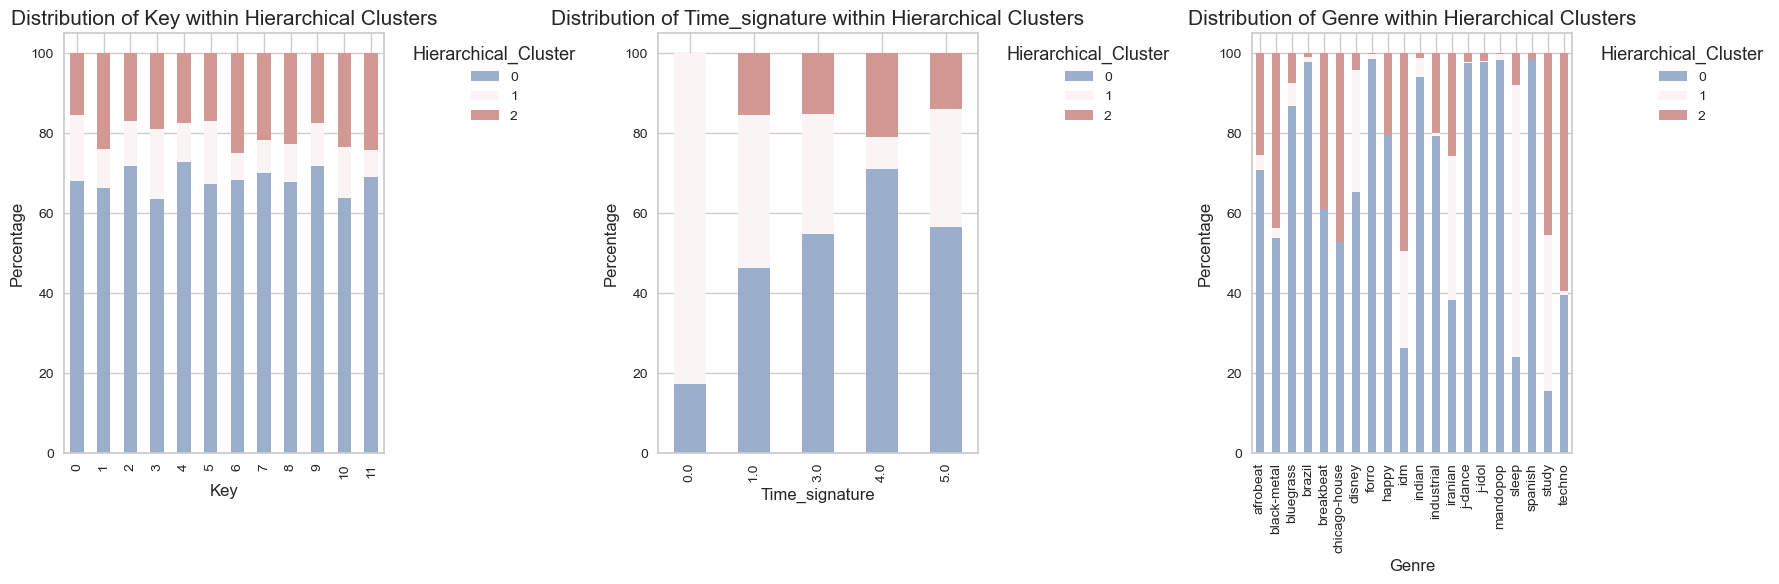

In [74]:
# Creating columns to store the clustering results
df['Hierarchical_Cluster'] = np.nan

# Using Agglomerative (Hierarchical) Clustering
dist_matrix = squareform(pdist(df_train, metric='euclidean'))
Hierarchical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
Hierarchical.fit(dist_matrix)
Hierarchical_labels = Hierarchical.labels_
df['Hierarchical_Cluster'] = Hierarchical_labels


# Clustering methods and features to plot
methods = ['Hierarchical_Cluster']
features = ['key', 'time_signature', 'genre']

# Creating a subplot layout for the charts

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the distribution of each cluster within each method

for i, feature in enumerate(features):
    ax = axes[i]
    crosstab_percentage = create_crosstab_percentage('Hierarchical_Cluster', feature)
    plot_stacked_percentage_bar(ax, crosstab_percentage, f'Distribution of {feature.capitalize()} within Hierarchical Clusters', feature.capitalize(), 'Percentage', 'Hierarchical_Cluster')

plt.tight_layout()
plt.show()
